# Prueba de modelos Machine Learning.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor,
    GradientBoostingClassifier,
    GradientBoostingRegressor,
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    roc_curve,
    roc_auc_score,
    mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.tree import (
    DecisionTreeClassifier,
    DecisionTreeRegressor,
    plot_tree
)
#from xgboost import XGBClassifier, XGBRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [4]:
PATH_DIRECTORIO_DATOS_PROCESSED = "../../data/processed"
df = pd.read_csv(f"{PATH_DIRECTORIO_DATOS_PROCESSED}/data_processed.csv", index_col = 0)

In [53]:
# Calculamos las métricas de evaluación
def calcular_metricas_evaluacion(y_prediccion: np.ndarray, y_real: np.ndarray, verbose: bool = True):
    """Calcula las métricas de evaluación para un modelo de regresión.
    
    Calcula cuatro métricas comunes para evaluar modelos de regresión: MSE (Error Cuadrático Medio),
    RMSE (Raíz del Error Cuadrático Medio), MAE (Error Absoluto Medio) y R² (Coeficiente de determinación).
    Opcionalmente imprime los resultados en un formato legible.
    
    Args:
        y_prediccion (np.ndarray): Valores predichos por el modelo.
        y_real (np.ndarray): Valores reales observados.
        verbose (bool, optional): Si es True, imprime las métricas calculadas. Por defecto es True.
    
    Returns:
        tuple[float, float, float, float]: Una tupla con cuatro valores en el siguiente orden:
            - mse: Error cuadrático medio.
            - rmse: Raíz del error cuadrático medio.
            - mae: Error absoluto medio.
            - r2: Coeficiente de determinación.
    
    Example:
        >>> mse, rmse, mae, r2 = calcular_metricas_evaluacion(modelo.predict(X_test), y_test)
        >>> print(f"R²: {r2:.4f}")
    """
    
    mse = mean_squared_error(y_real, y_prediccion)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_real, y_prediccion)
    r2 = r2_score(y_real, y_prediccion)

    if verbose:
        print("\nEvaluación del modelo:")
        print(f"MSE (Error cuadrático medio): {mse:.4f}")
        print(f"RMSE (Raíz del error cuadrático medio): {rmse:.4f}")
        print(f"MAE (Error absoluto medio): {mae:.4f}")
        print(f"R² (Coeficiente de determinación): {r2:.4f}")
        print(f"El modelo explica aproximadamente el {r2:.2%} de la varianza")
    
    return mse, rmse, mae, r2

In [54]:
df.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,has_company
hotel,,,,,,,,,,,,,,,,,,,,,
Resort Hotel,0,342,2015,7,27,1,0,0,2,0.0,...,C,3,No Deposit,Unknown,0,Transient,0.0,0,0,0
Resort Hotel,0,737,2015,7,27,1,0,0,2,0.0,...,C,4,No Deposit,Unknown,0,Transient,0.0,0,0,0
Resort Hotel,0,7,2015,7,27,1,0,1,1,0.0,...,C,0,No Deposit,Unknown,0,Transient,75.0,0,0,0
Resort Hotel,0,13,2015,7,27,1,0,1,1,0.0,...,A,0,No Deposit,304.0,0,Transient,75.0,0,0,0
Resort Hotel,0,14,2015,7,27,1,0,2,2,0.0,...,A,0,No Deposit,240.0,0,Transient,98.0,0,1,0


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119390 entries, Resort Hotel to City Hotel
Data columns (total 29 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     119390 non-null  int64  
 1   lead_time                       119390 non-null  int64  
 2   arrival_date_year               119390 non-null  int64  
 3   arrival_date_month              119390 non-null  int64  
 4   arrival_date_week_number        119390 non-null  int64  
 5   arrival_date_day_of_month       119390 non-null  int64  
 6   stays_in_weekend_nights         119390 non-null  int64  
 7   stays_in_week_nights            119390 non-null  int64  
 8   adults                          119390 non-null  int64  
 9   children                        119390 non-null  float64
 10  babies                          119390 non-null  int64  
 11  meal                            119390 non-null  object 
 12  countr

## Regresión Logística.

In [5]:
# Seleccionamos las columnas independientes
list_columnas_independientes = df.drop(columns='is_canceled').columns.to_list()
list_columnas_independientes

['lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'reserved_room_type',
 'assigned_room_type',
 'booking_changes',
 'deposit_type',
 'agent',
 'days_in_waiting_list',
 'customer_type',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'has_company']

In [6]:
# Preparación de los datos para el modelo de regresión logística
X = df[list_columnas_independientes]
y = df['is_canceled']

In [58]:
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include='object').columns

In [59]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

In [60]:
#Pipeline para el preprocesado de los datos y el modelo de RL.
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

In [61]:
# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
# Entrenamiento del modelo de regresión lineal
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['lead_time', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_c...
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'has_company'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['meal', 'country', 'market_segment', 'distribution_channel',
       'reserved_room_type', 'assigned_room_type', 'deposit_type', 'agent',
       'customer_type'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [63]:
y_pred = model.predict(X_test)

In [64]:
y_proba = model.predict_proba(X_test)[:, 1]

In [65]:
# Obtención de las métricas de evaluación
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Cálculo del AUC (Area Under the Curve)
auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy:  {acc:.2%}")
print(f"Precisión: {prec:.2%}")
print(f"Recall:    {rec:.2f}")
print(f"F1-Score:  {f1:.2f}")
print(f"AUC:       {auc:.2f}\n")

Accuracy:  83.41%
Precisión: 82.03%
Recall:    0.72
F1-Score:  0.76
AUC:       0.92



In [66]:
# Gracias a la función classification_report podemos obtener un reporte detallado de las métricas de evaluación
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87     14907
           1       0.82      0.72      0.76      8971

    accuracy                           0.83     23878
   macro avg       0.83      0.81      0.82     23878
weighted avg       0.83      0.83      0.83     23878



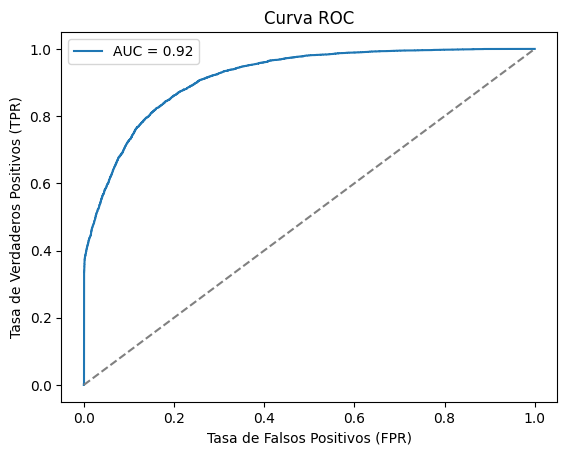

In [67]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

## Árbol de decisión.

In [68]:
#Pipeline para el preprocesado de los datos y el modelo de DT.
model_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=3, random_state=42))
])

In [69]:
# Entrenamos el modelo de árbol de decisión
model_dt.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['lead_time', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_c...
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'has_company'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['meal', 'country', 'market_segment', 'distribution_channel',
       'reserved_room_type', 'assigned_room_type', 'deposit_type', 'agent',
       'customer_type'],
      dtype='object'))])),
                ('classifier',
                 DecisionTreeClassifier(max_depth=3, random_state=42))])

In [70]:
# Hacemos predicciones sobre el conjunto de test
y_pred = model_dt.predict(X_test)

In [71]:
# Obtenemos las probabilidades de pertenencia a la clase positiva (1)
y_proba = model_dt.predict_proba(X_test)[:, 1]

In [72]:
# Obtención de las métricas de evaluación
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Cálculo del AUC (Area Under the Curve)
auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy:  {acc:.2f}")
print(f"Precisión: {prec:.2f}")
print(f"Recall:    {rec:.2f}")
print(f"F1-Score:  {f1:.2f}")
print(f"AUC:       {auc:.2f}\n")

Accuracy:  0.76
Precisión: 0.72
Recall:    0.60
F1-Score:  0.66
AUC:       0.79



In [73]:
# Gracias a la función classification_report podemos obtener un reporte detallado de las métricas de evaluación
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.78      0.86      0.82     14907
           1       0.72      0.60      0.66      8971

    accuracy                           0.76     23878
   macro avg       0.75      0.73      0.74     23878
weighted avg       0.76      0.76      0.76     23878



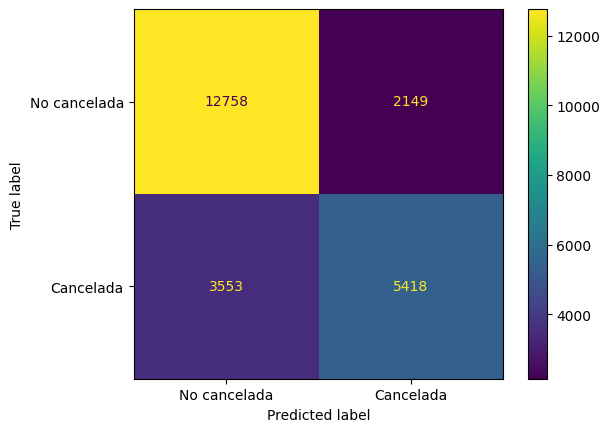

In [74]:
# Mostramos la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No cancelada', 'Cancelada'])
disp.plot()
plt.show()

## Random Forest.

In [97]:
#Pipeline para el preprocesado de los datos y el modelo de RF.
model_rfc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42))
])

In [98]:
# Entrenamos el modelo de Random Forest
model_rfc.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['lead_time', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_c...
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'has_company'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['meal', 'country', 'market_segment', 'distribution_channel',
       'reserved_room_type', 'assigned_room_type', 'deposit_type', 'agent',
       'customer_type'],
      dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(max_depth=3, random_state=42))])

In [99]:
# Hacemos predicciones sobre el conjunto de test
y_pred = model_rfc.predict(X_test)

# Obtención de las métricas de evaluación
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Cálculo del AUC (Area Under the Curve)
y_proba = model_rfc.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy:  {acc:.2f}")
print(f"Precisión: {prec:.2f}")
print(f"Recall:    {rec:.2f}")
print(f"F1-Score:  {f1:.2f}")
print(f"AUC:       {auc:.2f}\n")

Accuracy:  0.75
Precisión: 1.00
Recall:    0.33
F1-Score:  0.50
AUC:       0.87



In [92]:
model_rfc[1]

RandomForestClassifier(max_depth=3, random_state=42)

In [101]:
# Importancia de variables
col_importancia_rf = model_rfc[1].feature_importances_

##df_importances_rf = pd.DataFrame({'variable' : X.columns, 'importancia' : col_importancia_rf})

In [ ]:
df_importances_rf = df_importances_rf.sort_values(by='importancia', ascending=True)

In [ ]:
# Visualización de la importancia de las variables
fig = px.bar(
    df_importances_rf,
    x='importancia',
    y='variable',
    text='importancia',
    text_auto=".3%",
    title='Importancia de las variables en el modelo Random Forest',
    labels={'x': 'Importancia', 'y': 'Variable'},
    width=700, height=500
)
fig.update_layout(xaxis_tickangle=-45)
fig.show()

## XGBoost.

## Red neuronal.

### Arquitectura ONE HOT ENCODING + MLP (densa).

In [7]:
X_dummy = pd.get_dummies(X, drop_first=True)

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dummy)

In [9]:
X_scaled.shape

(119390, 569)

In [10]:
y.shape

(119390,)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [12]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])

/Users/user/machine_deep_learning/proyecto-final-ml/env-pontia-ml/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [14]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=256,
    verbose=1
)

Epoch 1/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7183 - loss: 0.5457 - val_accuracy: 0.8348 - val_loss: 0.3481
Epoch 2/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8251 - loss: 0.3660 - val_accuracy: 0.8459 - val_loss: 0.3236
Epoch 3/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8384 - loss: 0.3385 - val_accuracy: 0.8506 - val_loss: 0.3175
Epoch 4/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8435 - loss: 0.3290 - val_accuracy: 0.8532 - val_loss: 0.3083
Epoch 5/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8492 - loss: 0.3204 - val_accuracy: 0.8571 - val_loss: 0.3040
Epoch 6/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8549 - loss: 0.3103 - val_accuracy: 0.8615 - val_loss: 0.3004
Epoch 7/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8560 - loss: 0.3073 - val_accuracy: 0.8627 - val_loss: 0.2968
Epoch 8/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8557 - loss: 0.3035 - val_accuracy: 0.

In [15]:
y_pred = (model.predict(X_test) > 0.5).astype(int)

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, model.predict(X_test)))

747/747 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
              precision    recall  f1-score   support

           0       0.89      0.92      0.90     14907
           1       0.85      0.81      0.83      8971

    accuracy                           0.88     23878
   macro avg       0.87      0.87      0.87     23878
weighted avg       0.88      0.88      0.88     23878

747/747 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step
ROC AUC: 0.9520627264808169
